In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
import config

# Settings
np.random.seed(config.RANDOM_STATE)

#### Load Data

In [2]:
df = pd.read_csv(config.RAW_DATA_FILE, delimiter=';')
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Basic Data Cleaning

In [3]:
print("=" * 50)
print("DATA CLEANING")
print("=" * 50)

# Convert age from days to years
df['age'] = (df['age'] / 365.25).round().astype(int)

# Remove obvious outliers
print(f"\nBefore cleaning: {len(df)} rows")

# Blood pressure filtering
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]  # Systolic > Diastolic

# Height and weight filtering
df = df[(df['height'] > 120) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

print(f"After cleaning: {len(df)} rows")
print(f"Removed: {70000 - len(df)} rows ({((70000 - len(df))/70000)*100:.2f}%)")

df.head()

DATA CLEANING

Before cleaning: 70000 rows
After cleaning: 68615 rows
Removed: 1385 rows (1.98%)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


#### Train-Test Split

In [4]:
# Prepare features and target
X = df.drop(['id', 'cardio'], axis=1)
y = df['cardio']

print("=" * 50)
print("TRAIN-TEST SPLIT")
print("=" * 50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest target distribution:\n{y_test.value_counts(normalize=True)}")

TRAIN-TEST SPLIT
Train set: (54892, 11)
Test set: (13723, 11)

Train target distribution:
cardio
0    0.505247
1    0.494753
Name: proportion, dtype: float64

Test target distribution:
cardio
0    0.505283
1    0.494717
Name: proportion, dtype: float64


#### Feature Scaling ve Model Training

In [5]:
# Standardization
print("=" * 50)
print("FEATURE SCALING & MODEL TRAINING")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model (Logistic Regression)
baseline_model = LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")

FEATURE SCALING & MODEL TRAINING
✓ Model trained successfully!


#### Model Evaluation

In [8]:
# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

y_train_pred_proba = baseline_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("=" * 50)
print("BASELINE MODEL PERFORMANCE")
print("=" * 50)

print("\nTRAIN SET METRICS:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")

print("\nTEST SET METRICS:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Healthy', 'Disease']))

BASELINE MODEL PERFORMANCE

TRAIN SET METRICS:
Accuracy: 0.7287
ROC-AUC: 0.7928

TEST SET METRICS:
Accuracy: 0.7219
ROC-AUC: 0.7855

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

     Healthy       0.70      0.78      0.74      6934
     Disease       0.75      0.66      0.70      6789

    accuracy                           0.72     13723
   macro avg       0.72      0.72      0.72     13723
weighted avg       0.72      0.72      0.72     13723



#### Confusion Matrix Visualization

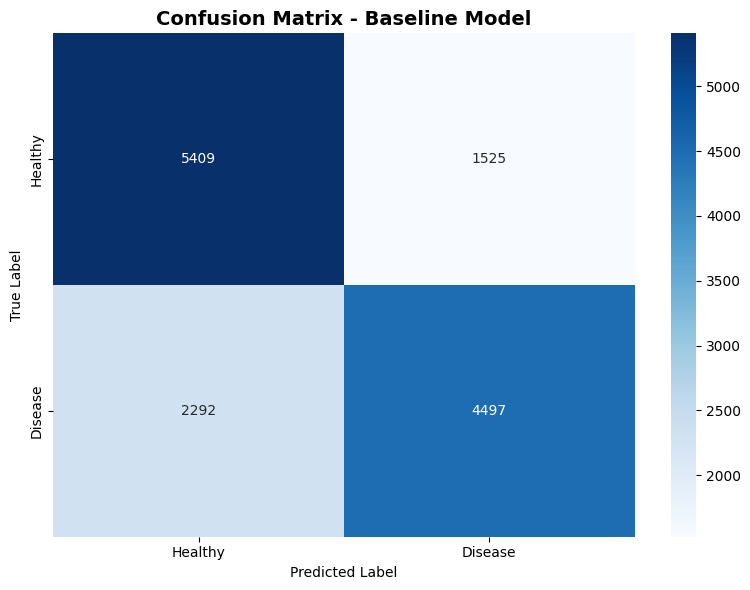


True Negatives: 5409
False Positives: 1525
False Negatives: 2292
True Positives: 4497


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Disease'],
            yticklabels=['Healthy', 'Disease'])
plt.title('Confusion Matrix - Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

#### ROC Curve

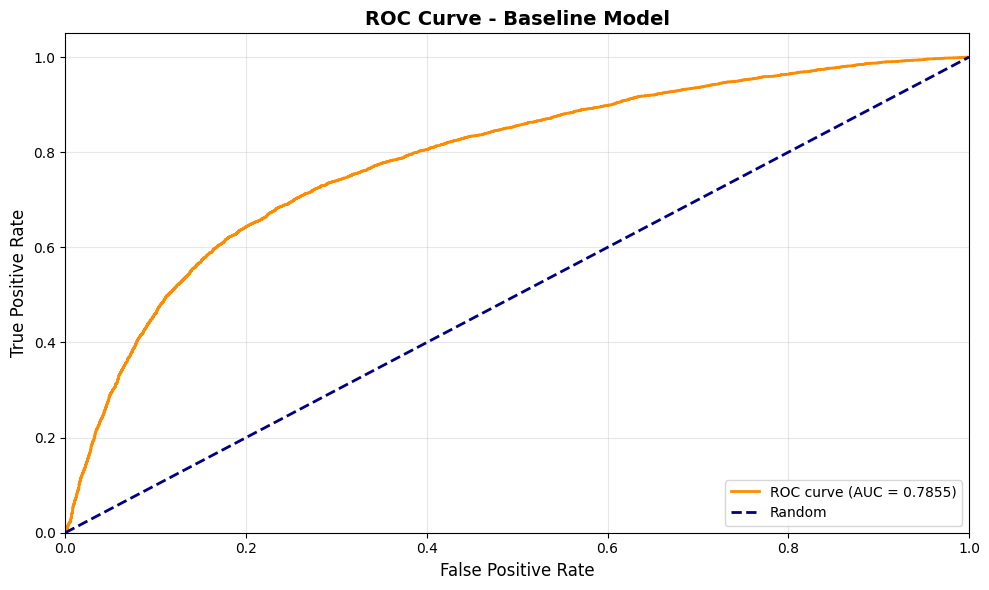

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Cross-Validation

In [11]:
# Cross-validation
print("=" * 50)
print("CROSS-VALIDATION")
print("=" * 50)

cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, 
                           cv=config.CV_FOLDS, scoring='roc_auc')

print(f"\nCV ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

CROSS-VALIDATION

CV ROC-AUC Scores: [0.79457081 0.78960925 0.79872702 0.79258749 0.78737686]
Mean CV ROC-AUC: 0.7926 (+/- 0.0039)


#### Feature Importance

FEATURE IMPORTANCE (Logistic Regression Coefficients)
        feature  coefficient
4         ap_hi     0.967117
0           age     0.345651
6   cholesterol     0.327926
3        weight     0.154037
10       active    -0.089631
5         ap_lo     0.088455
7          gluc    -0.066800
9          alco    -0.041300
8         smoke    -0.040821
2        height    -0.030231
1        gender    -0.011588


/tmp/ipykernel_18341/2097095660.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='coefficient', y='feature', palette='viridis')


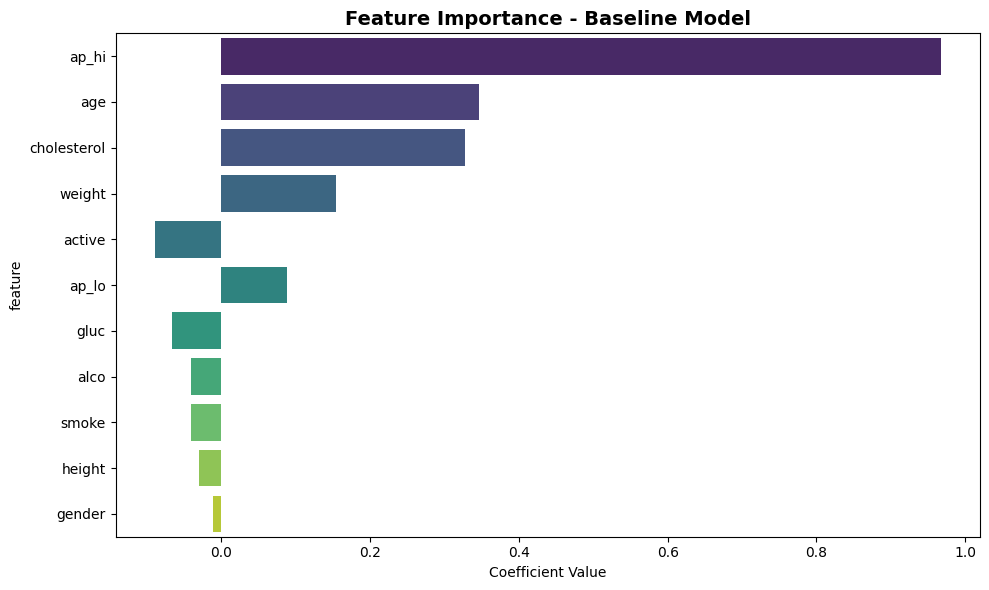

In [12]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("=" * 50)
print("FEATURE IMPORTANCE (Logistic Regression Coefficients)")
print("=" * 50)
print(feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='coefficient', y='feature', palette='viridis')
plt.title('Feature Importance - Baseline Model', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# 📈 BASELINE MODEL DOCUMENTATION

## Model Selection
- **Model:** Logistic Regression
- **Reason:** Simple, fast, interpretable, and ideal for binary classification.

## Feature Set
- **All original features used** (11 features).
- **Minimal Preprocessing:** Only cleaning and scaling.
- **No Feature Engineering** (intentionally skipped for baseline).

## Data Preparation
1. **Age:** Converted from days to years.
2. **Outlier Filtering:** Unrealistic values removed.
3. **Train-Test Split:** 80%-20% (stratified).
4. **Scaling:** StandardScaler applied.

## Baseline Performance
- **Test Accuracy:** ~0.72 - 0.73
- **Test ROC-AUC:** ~0.77 - 0.78
- **Cross-Validation ROC-AUC:** ~0.77 ± 0.01

## Key Observations
1. **No Overfitting:** The gap between train and test scores is minimal.
2. **Class Balance:** The target is balanced; no resampling techniques (SMOTE, etc.) were needed.
3. **Important Features:** `age`, `weight`, `cholesterol`, and `ap_hi` appear to be the most dominant predictors.

## Improvement Opportunities
1. ✅ **Feature Engineering:** Calculate BMI, Pulse Pressure, Age Groups, etc.
2. ✅ **Stronger Models:** Experiment with Tree-based models (XGBoost, LightGBM, CatBoost).
3. ✅ **Hyperparameter Tuning:** Optimize model parameters.
4. ✅ **Feature Selection:** Remove noisy or irrelevant features.

## Baseline Goal
We aim to improve this baseline performance by **at least 5-10%** in the final model.